In [43]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census
import gmaps
import time
from us import states
from scipy.stats import linregress
from matplotlib import pyplot as plt

# API Keys
from config import (census_key, gkey)
c = Census(census_key, year=2017)

In [44]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E", "B17001_002E", "B02001_002E", "B02001_005E", 
                          "B02001_003E", "B02001_004E", "B02001_007E"), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B02001_002E": "White Population",
                                      "B02001_004E": "Native American Population",
                                      "B02001_005E": "Asian Population",
                                      "B02001_003E": "African American Population",
                                      "B02001_007E": "Other Population",
                                      "NAME": "Name", 
                                      "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate", "White Population", "Native American Population", 
                       "Asian Population", "African American Population", "Other Population"]]

# Visualize
census_pd.head(10)
census_pd["Zipcode"] = census_pd["Zipcode"].astype('int64')


In [45]:
file_to_load = "covid_zip"

# Read Purchasing File and store into Pandas data frame
covid_df = pd.read_csv(file_to_load)
covid_df = covid_df.rename(columns = {"POSTCODE" : "Zipcode"})


In [46]:
merged_df = pd.merge(covid_df, census_pd, on="Zipcode", how="left")
merged_df.drop(columns=["Unnamed: 0"])

,Zipcode,ConfirmedCaseCategory,ConfirmedCaseCount,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,White Population,Native American Population,Asian Population,African American Population,Other Population
0,85003,Greater Than 250,277.0,8694.0,39.2,47554.0,36513.0,1662.0,19.116632,6861.0,278.0,104.0,856.0,382.0
1,85004,101-250,206.0,5944.0,32.3,33862.0,31679.0,1772.0,29.811575,4601.0,103.0,331.0,386.0,339.0
2,85006,Greater Than 250,837.0,27671.0,31.0,32166.0,16583.0,10919.0,39.460085,13571.0,827.0,158.0,1303.0,10839.0
3,85007,Greater Than 250,639.0,14810.0,33.2,31396.0,20438.0,5273.0,35.604321,8497.0,392.0,512.0,2056.0,2874.0
4,85008,Greater Than 250,2415.0,60700.0,28.7,37696.0,17694.0,18762.0,30.909390,31891.0,2009.0,556.0,7113.0,16602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,86514,Data Suppressed,NaN,2734.0,37.6,24199.0,12098.0,1209.0,44.220922,41.0,2672.0,5.0,2.0,6.0
406,86515,0,0.0,4933.0,33.8,35417.0,13441.0,1473.0,29.860126,254.0,4391.0,45.0,20.0,76.0
407,86515,Data Suppressed,NaN,4933.0,33.8,35417.0,13441.0,1473.0,29.860126,254.0,4391.0,45.0,20.0,76.0
408,86538,Data Suppressed,NaN,2080.0,28.9,26304.0,11644.0,888.0,42.692308,53.0,2015.0,2.0,7.0,3.0


In [47]:
file_to_load = "us-zip-code-latitude-and-longitude.csv"

# Read Purchasing File and store into Pandas data frame
lat_lon_df = pd.read_csv(file_to_load, delimiter=";")
lat_lon_df = lat_lon_df.drop(columns=["City", "State", "Timezone", "Daylight savings time flag", "geopoint"])
lat_lon_df = lat_lon_df.rename(columns = {"Zip" : "Zipcode"})

In [48]:
merged_df = pd.merge(merged_df, lat_lon_df, on="Zipcode", how="left")

merged_df

,Unnamed: 0,Zipcode,ConfirmedCaseCategory,ConfirmedCaseCount,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,White Population,Native American Population,Asian Population,African American Population,Other Population,Latitude,Longitude
0,0,85003,Greater Than 250,277.0,8694.0,39.2,47554.0,36513.0,1662.0,19.116632,6861.0,278.0,104.0,856.0,382.0,33.451143,-112.07838
1,1,85004,101-250,206.0,5944.0,32.3,33862.0,31679.0,1772.0,29.811575,4601.0,103.0,331.0,386.0,339.0,33.451093,-112.07057
2,2,85006,Greater Than 250,837.0,27671.0,31.0,32166.0,16583.0,10919.0,39.460085,13571.0,827.0,158.0,1303.0,10839.0,33.466392,-112.04875
3,3,85007,Greater Than 250,639.0,14810.0,33.2,31396.0,20438.0,5273.0,35.604321,8497.0,392.0,512.0,2056.0,2874.0,33.449995,-112.09024
4,4,85008,Greater Than 250,2415.0,60700.0,28.7,37696.0,17694.0,18762.0,30.909390,31891.0,2009.0,556.0,7113.0,16602.0,33.466393,-112.00080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,405,86514,Data Suppressed,NaN,2734.0,37.6,24199.0,12098.0,1209.0,44.220922,41.0,2672.0,5.0,2.0,6.0,36.880920,-109.33634
406,406,86515,0,0.0,4933.0,33.8,35417.0,13441.0,1473.0,29.860126,254.0,4391.0,45.0,20.0,76.0,35.672842,-109.06495
407,407,86515,Data Suppressed,NaN,4933.0,33.8,35417.0,13441.0,1473.0,29.860126,254.0,4391.0,45.0,20.0,76.0,35.672842,-109.06495
408,408,86538,Data Suppressed,NaN,2080.0,28.9,26304.0,11644.0,888.0,42.692308,53.0,2015.0,2.0,7.0,3.0,36.374317,-109.60070


In [61]:
gmaps.configure(api_key=gkey)

# Store 'Lat' and 'Lng' into  locations 
locations = merged_df[["Latitude", "Longitude"]].astype(float)

# Convert Poverty Rate to float and store
# HINT: be sure to handle NaN values
#merged_df = merged_df.dropna()
infection_rate = merged_df["ConfirmedCaseCount"].astype(float)

fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=infection_rate)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

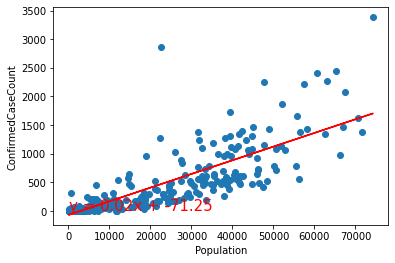

In [62]:
x_values = merged_df["Population"]
y_values = merged_df["ConfirmedCaseCount"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Population')
plt.ylabel('ConfirmedCaseCount')
plt.show()

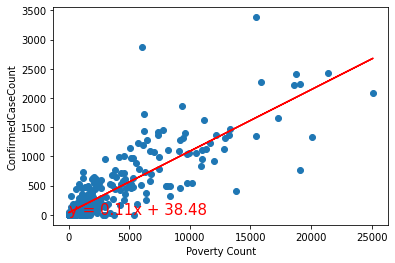

In [63]:
x_values = merged_df["Poverty Count"]
y_values = merged_df["ConfirmedCaseCount"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Poverty Count')
plt.ylabel('ConfirmedCaseCount')
plt.show()

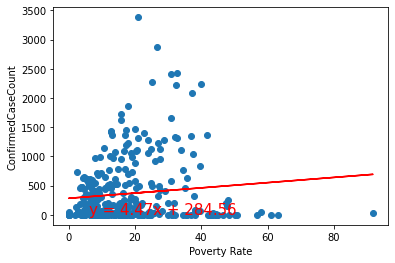

In [64]:
x_values = merged_df["Poverty Rate"]
y_values = merged_df["ConfirmedCaseCount"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Poverty Rate')
plt.ylabel('ConfirmedCaseCount')
plt.show()

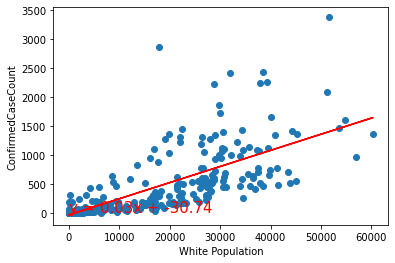

In [65]:
x_values = merged_df["White Population"]
y_values = merged_df["ConfirmedCaseCount"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('White Population')
plt.ylabel('ConfirmedCaseCount')
plt.show()

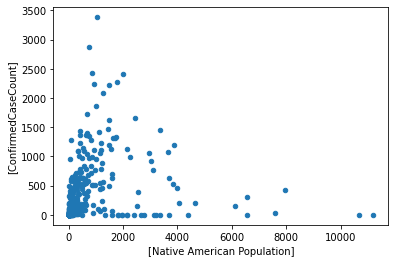

In [54]:
x_values = merged_df["Native American Population"]
y_values = merged_df["ConfirmedCaseCount"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Native American Population')
plt.ylabel('ConfirmedCaseCount')
plt.show()

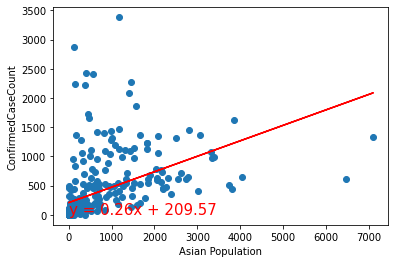

In [66]:
x_values = merged_df["Asian Population"]
y_values = merged_df["ConfirmedCaseCount"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Asian Population')
plt.ylabel('ConfirmedCaseCount')
plt.show()

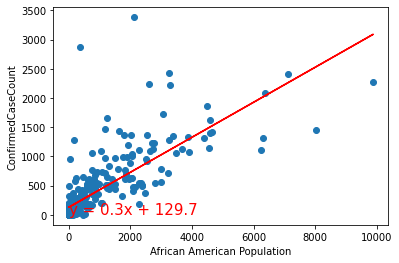

In [67]:
x_values = merged_df["African American Population"]
y_values = merged_df["ConfirmedCaseCount"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('African American Population')
plt.ylabel('ConfirmedCaseCount')
plt.show()

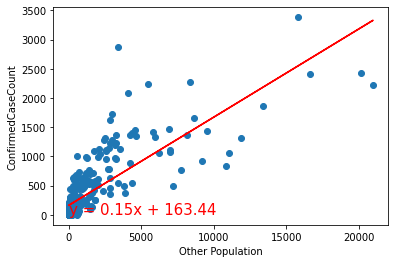

In [68]:
x_values = merged_df["Other Population"]
y_values = merged_df["ConfirmedCaseCount"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Other Population')
plt.ylabel('ConfirmedCaseCount')
plt.show()